In [28]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess

In [2]:
# spreading rate, m/yr
rate = 0.02

In [12]:
# run the C program and output to out.temp
def run_thermal_model(model,rate):
    if model == 1:
        model_name = 'sleep_cooling '
    elif model == 2:
        model_name = 'sleep_modified '
    else:
        model_name = 'sleep_cooling '
    runcmd = model_name + str(rate)
    outfile = open("out.temp","w")
    subprocess.call(runcmd,stdout=outfile,shell=True)

In [29]:
# read data into numpy array
def read_thermal_model(outfile):
    data = np.loadtxt(fname=outfile)
    # extract top row and first columns (x and z coords)
    x_coords = data[0,1:] / 1000;
    z_coords = data[1:,0] / -1000;
    temps = np.transpose(data[1:,1:])
    return x_coords,z_coords,temps

In [39]:
# simple plotting of thermal models
def plot_thermal_profiles(x,z,t):
    plt.plot(t[:,0],z,label='On axis')
    plt.plot(t[:,149],z,label='X = 15 km')
    plt.plot(t[:,299],z,label='X = 30 km')
    plt.xlabel('Temperature (C)')
    plt.ylabel('Depth (km)')
    plt.legend()
    plt.show()

In [53]:
def plot_thermal_contours(x,z,t):
    # make mesh
    X,Z = np.meshgrid(x,z)
    TC = plt.contour(X,Z,t,colors='k',levels=[0, 300, 600, 800, 1000, 1185])
    plt.clabel(TC,fmt="%.0f")
    plt.show()

In [30]:
run_thermal_model(1,rate)
x_coords, z_coords, temps = read_thermal_model('out.temp')

In [41]:
X,Z = np.meshgrid(x_coords,z_coords)

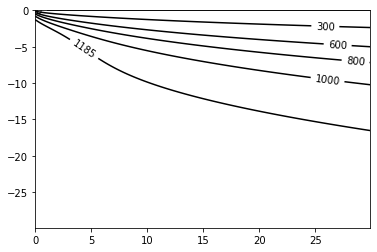

In [52]:
TC = plt.contour(X,Z,temps,colors='k',levels=[0, 300, 600, 800, 1000, 1185])
plt.clabel(TC,fmt="%.0f")
plt.show()